In [88]:
#!pip install vincenty

In [89]:
#!pip install -U imbalanced-learn

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import io

from vincenty import vincenty 
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV




import time
from datetime import datetime
%autocall 1

Automatic calling is: Smart


# Functions Used

In [3]:
def bootstrap_sample(values, statistic, num_samples):
    #bootstrapping samples
    
    bootstrap_stat = []
    for _ in range(num_samples):
        subset = np.random.choice(values, size = 1000, replace = True)
        stat = statistic(subset)
        bootstrap_stat.append(stat)

    return bootstrap_stat



#bootstrap_sample(values, np.mean, 1000)

# Importing Datasets




In [4]:
train = pd.read_csv("west_nile/input/train.csv")
test = pd.read_csv("west_nile/input/test.csv")
spray = pd.read_csv("west_nile/input/spray.csv")
weather = pd.read_csv("west_nile/input/weather.csv")

In [5]:
#spray = pd.read_csv(io.StringIO(spray_file['spray.csv'].decode('utf-8')))
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
# weather_file = files.upload()
# weather = pd.read_csv(io.StringIO(weather_file['weather.csv'].decode('utf-8')), na_values = ['M'])
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [7]:
#train_file = files.upload()
# train = pd.read_csv(io.StringIO(train_file['train.csv'].decode('utf-8')))
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [8]:
#import Test File
# test_file = files.upload()
# test = pd.read_csv(io.StringIO(test_file['test.csv'].decode('utf-8')))
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


# EDA

In [9]:
null_vals = train.isnull().sum()
shape = train.shape
dtypes = train.dtypes
df_output = pd.DataFrame()
df_output["Nulls"] = null_vals
df_output["dtypes"] = dtypes
print("SHAPE:",df_output.shape)
df_output

SHAPE: (12, 2)


,Nulls,dtypes
Date,0,object
Address,0,object
Species,0,object
Block,0,int64
Street,0,object
Trap,0,object
AddressNumberAndStreet,0,object
Latitude,0,float64
Longitude,0,float64
AddressAccuracy,0,int64


In [10]:
def EDA(df,name):
    null_vals = df.isnull().sum()
    shape = df.shape
    dtypes = df.dtypes
    df_output = pd.DataFrame()
    df_output["Nulls"] = null_vals
    df_output["dtypes"] = dtypes
    print("=======================================\n")
    print(name.upper())
    print("SHAPE:",df_output.shape,"\n")
    return df_output

In [11]:
print(EDA(train,'train'))
print(EDA(test,'test'))
print(EDA(spray,'spray'))
print(EDA(weather,'weather'))
#print(EDA(sample))


TRAIN
SHAPE: (12, 2) 

                        Nulls   dtypes
Date                        0   object
Address                     0   object
Species                     0   object
Block                       0    int64
Street                      0   object
Trap                        0   object
AddressNumberAndStreet      0   object
Latitude                    0  float64
Longitude                   0  float64
AddressAccuracy             0    int64
NumMosquitos                0    int64
WnvPresent                  0    int64

TEST
SHAPE: (11, 2) 

                        Nulls   dtypes
Id                          0    int64
Date                        0   object
Address                     0   object
Species                     0   object
Block                       0    int64
Street                      0   object
Trap                        0   object
AddressNumberAndStreet      0   object
Latitude                    0  float64
Longitude                   0  float64
AddressAccuracy  

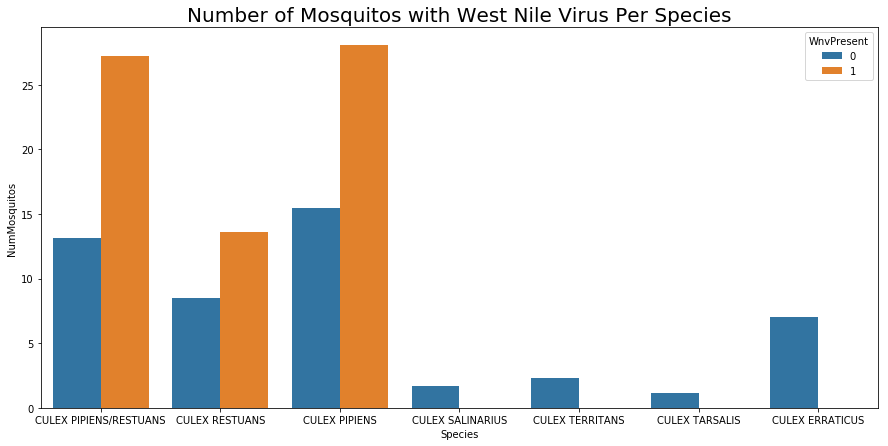

In [29]:

grouped2 = train.groupby(["Species","WnvPresent"])
grouped2["NumMosquitos"].sum()

plt.subplots(figsize=(15,7))
plt.title("Number of Mosquitos with West Nile Virus Per Species",{'fontsize':20})
sns.barplot(x="Species", y="NumMosquitos", hue="WnvPresent", data=train, ci =None)


In [62]:
train.head()
train.tail()
#train["Month"] = train["Date"].apply(lambda x: int(x[5:7]))

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Month,Week,Day,Month_Day
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1,9,42,26,"(9, 26)"
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0,9,42,26,"(9, 26)"
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0,9,42,26,"(9, 26)"
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0,9,42,26,"(9, 26)"
10505,2013-09-26,"4200 West 65th Street, Chicago, IL 60621, USA",CULEX PIPIENS/RESTUANS,42,W 65TH ST,T235,"4200 W 65TH ST, Chicago, IL",41.776428,-87.627096,8,1,0,9,42,26,"(9, 26)"


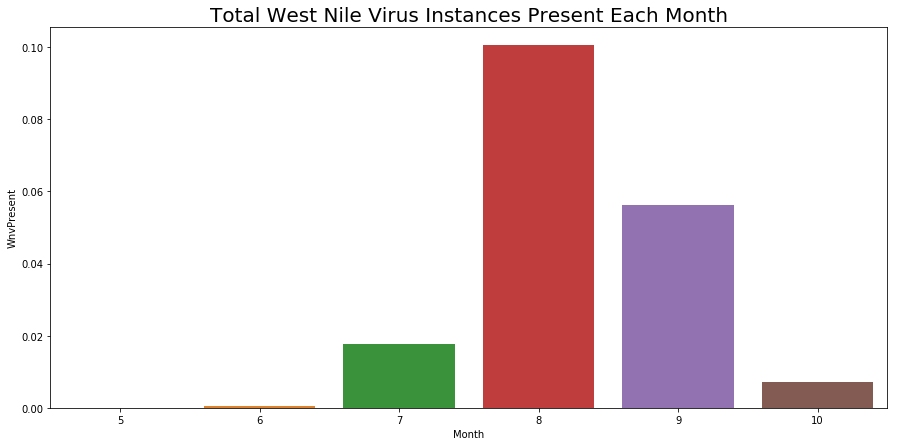

In [41]:
plt.subplots(figsize=(15,7))
plt.title("Total West Nile Virus Instances Present Each Month",{"fontsize":20})
sns.barplot(x="Month",y="WnvPresent",data=train,ci=None)

In [60]:
Month_Day = {'1':31,'2':28,'3':31,'4':30,'5':31,'6':30,'7':31,'8':31,'9':30,'10':31,'11':30,'12':31}
Month_Days = list(Month_Day.values())
Month_Days

AttributeError: 'list' object has no attribute 'sum'

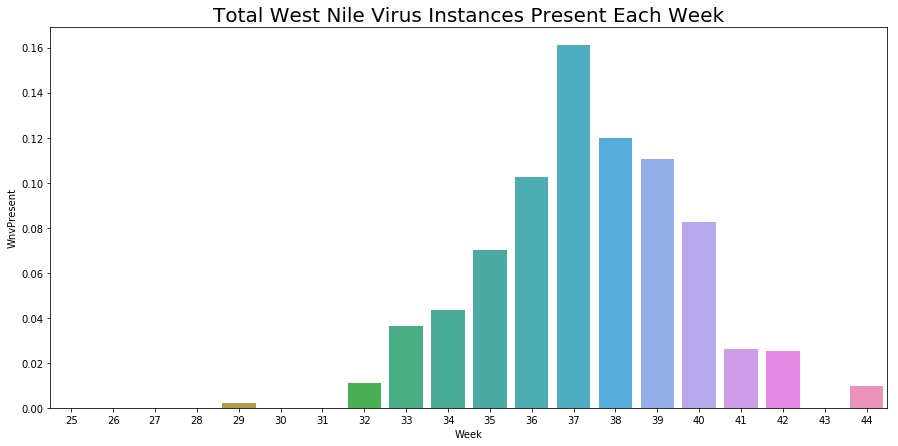

In [61]:
train["Day"] = train["Date"].apply(lambda x: int(x[-2:]))
train["Month_Day"] = list(zip( train["Month"] , train["Day"] ))
train["Week"] = train["Month_Day"].apply(lambda x : (sum(Month_Days[:x[0]]) + x[1])//7)

plt.subplots(figsize=(15,7))
plt.title("Total West Nile Virus Instances Present Each Week",{"fontsize":20})
sns.barplot(x="Week",y="WnvPresent",data=train,ci=None)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

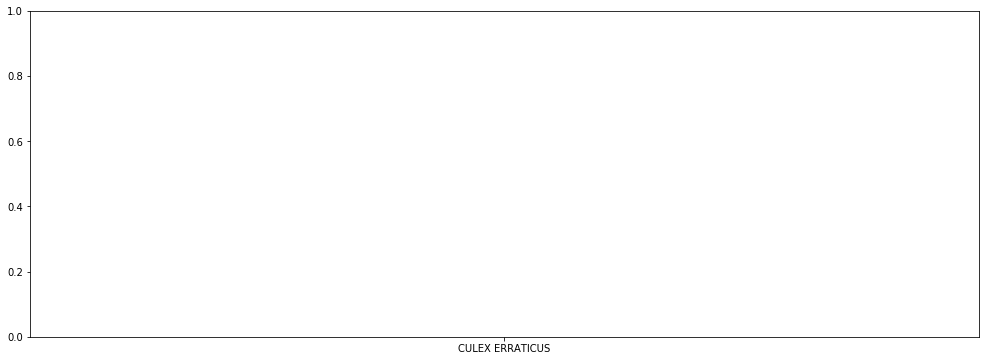

In [19]:
grouped_percentage = pd.DataFrame()
grouped_percentage["NumMosquitos"] = grouped["NumMosquitos"].sum()
grouped_percentage["Number of Total Instances"] = train["Species"].value_counts()
grouped_percentage["WnvNotPresent Rate"] = grouped["WnvPresent"].apply(lambda x : x.value_counts()[0]/len(x) )
grouped_percentage["WnvPresent Rate"] = 1 - grouped_percentage["WnvNotPresent Rate"]
grouped_percentage["WnvNotPresent Instances"] = grouped_percentage["Number of Total Instances"] * grouped_percentage["WnvNotPresent Rate"]
grouped_percentage["WnvPresent Instances"] = grouped_percentage["Number of Total Instances"] - grouped_percentage["WnvNotPresent Instances"]

#grouped_percentage

plt.figure(figsize=(17,6))
plt.bar(grouped_percentage.index ,grouped2["NumMosquitos"].sum())

In [101]:
# date is an object an int
def convert_date(df):
    df['Date'] = pd.to_datetime(df['Date'])

In [102]:
convert_date(train)
convert_date(test)
convert_date(weather)

# Clean up data

In [103]:
#Create new column for combined Lat and Long
train['LatLong'] = list(zip(train.Latitude, train.Longitude))
test['LatLong'] = list(zip(test['Latitude'], test['Longitude']))

In [104]:
station1 = (41.995, -87.933)
station2 = (41.786, -87.752)

#Create closest station column
train['Closest_Station'] = [ 1 if vincenty(x,station1) < vincenty(x,station2) else 2 for x in train['LatLong']]
test['Closest_Station'] = [ 1 if vincenty(x,station1) < vincenty(x,station2) else 2 for x in test['LatLong']]

In [105]:
#Merge DataFrames train and weather on Date and Closest station

train_weather = train.merge(weather,how = 'left', left_on = ['Date','Closest_Station'],right_on =['Date','Station'])
test_weather = test.merge(weather,how = 'left', left_on = ['Date','Closest_Station'],right_on =['Date','Station'])

In [106]:
#Drop columns
train_weather = train_weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat','StnPressure', 'AvgSpeed','ResultSpeed','ResultDir'])
test_weather = test_weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat','StnPressure', 'AvgSpeed','ResultSpeed','ResultDir'])

In [107]:
#filling in missing(M) and trace(T)

weather_dataset = train_weather.columns.tolist()

for col in weather_dataset:
    for row in range(train_weather.shape[0]):
        if train_weather.loc[row, col] == 'M' or train_weather.loc[row, col] == '  T':
            train_weather.loc[row, col] = train_weather.loc[row - 1, col]

In [108]:
#filling in missing(M) and trace(T)

weather_dataset2 = test_weather.columns.tolist()

for col in weather_dataset2:
    for row in range(test_weather.shape[0]):
        if test_weather.loc[row, col] == 'M' or test_weather.loc[row, col] == '  T':
            test_weather.loc[row, col] = test_weather.loc[row - 1, col]

In [109]:
#Convert object types into numeric types

weather_object_dtypes = ['Tavg', 'WetBulb', 'PrecipTotal']

for col in weather_object_dtypes:
    train_weather[col] = pd.to_numeric(train_weather[col])
    test_weather[col] = pd.to_numeric(test_weather[col])

In [110]:
#FILL 'WetBulb' NAs with the MEAN
train_weather['WetBulb'].fillna(train_weather['WetBulb'].mean(),inplace = True)
test_weather['WetBulb'].fillna(test_weather['WetBulb'].mean(),inplace = True)

In [111]:
#FILL 'PrecipTotal' NAs with the MEAN
train_weather['PrecipTotal'].fillna(train_weather['PrecipTotal'].mean(), inplace = True)
test_weather['PrecipTotal'].fillna(test_weather['PrecipTotal'].mean(), inplace = True)

In [112]:
# TRAIN interaction features 
# train_weather['wet_temp'] = train_weather['PrecipTotal']*train_weather['Tavg']
# train_weather['wet_temp_roll'] = train_weather['wet_temp'].rolling(3).mean()
# train_weather['wet_temp_roll'].fillna(0, inplace = True)
# train_weather['wet_temp_roll_shift'] = train_weather['wet_temp_roll'].shift(14)
# train_weather['wet_temp_roll_shift'].fillna(0, inplace = True)



In [113]:
train_weather.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,WnvPresent,LatLong,Closest_Station,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,"(41.95469, -87.800991)",1,1,88,60,74,58,65,0.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,0,"(41.95469, -87.800991)",1,1,88,60,74,58,65,0.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,0,"(41.994991, -87.769279)",1,1,88,60,74,58,65,0.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,"(41.974089, -87.824812)",1,1,88,60,74,58,65,0.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,0,"(41.974089, -87.824812)",1,1,88,60,74,58,65,0.0


In [114]:
# TEST interaction features
# test_weather['wet_temp'] = test_weather['PrecipTotal']*test_weather['Tavg']
# test_weather['wet_temp_roll'] = test_weather['wet_temp'].rolling(3).mean()
# test_weather['wet_temp_roll'].fillna(0, inplace = True)
# test_weather['wet_temp_roll_shift'] = test_weather['wet_temp_roll'].shift(14)
# test_weather['wet_temp_roll_shift'].fillna(0, inplace = True)

In [115]:
# def mosquito(df):
#     #split wnv transmitting mosquito species lines into separate columns
    
#     df['CULEX PIPIENS'] = 0
#     df['CULEX RESTUANS'] = 0
    
#     for row in range(df.shape[0]):
#         if df.loc[row, 'Species'] == 'CULEX PIPIENS/RESTUANS':
#             df.loc[row, 'CULEX PIPIENS'] == 1
#             df.loc[row, 'CULEX RESTUANS'] == 1
#         elif df.loc[row, 'Species'] == 'CULEX PIPIENS':
#             df.loc[row, 'CULEX PIPIENS'] == 1
#         elif df.loc[row, 'Species'] == 'CULEX RESTUANS':
#             df.loc[row, 'CULEX RESTUANS'] == 1
            
    
#     df.drop(columns = ['Species'], inplace = True)

In [116]:
#call function
# mosquito(train_weather)
# mosquito(test_weather)

In [117]:
# Feature Selection

# define target
target = 'WnvPresent'

# instantiate selector
selector = SelectKBest(f_classif, k = 'all')

# subset training data without 'drops'

train_features = train_weather.drop('WnvPresent', axis=1).select_dtypes(include=['number'])

# subset training target
train_target = train_weather[target]

# fit selector
selector.fit(train_features, train_target)

# extract best feature indexes
best_features = selector.get_support(indices=True)

# convert indexes to feature names
features = list(train_features.columns[selector.get_support(indices = True)])
print(features)



['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'Closest_Station', 'Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal']


In [120]:
# Train-Train-Split on Data Set

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

features = ['Block', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal']
#, 'wet_temp_roll_shift', 'CULEX PIPIENS', 'CULEX RESTUANS'
X = train_weather[features]
y = train_weather['WnvPresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Standard Scaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


In [121]:
def drop_columns(df1, df2):
    #drop columns in either test/train that are not in the other
    
    df1cols = df1.columns.tolist()
    df2cols = df2.columns.tolist()
    
    notindf1cols = []
    notindf2cols = []
    
    for col in df1cols:
        if col not in df2cols:
            notindf2cols.append(col)
    
    for col in df2cols:
        if col not in df1cols:
            notindf1cols.append(col)
            
    df1.drop(columns = notindf2cols, inplace = True)
    df2.drop(columns = notindf1cols, inplace = True)

In [122]:
drop_columns(test_weather, train_weather)


In [123]:
# Try to Balance Classes with SMOTEENN
from sklearn.metrics import recall_score
from imblearn.combine import SMOTEENN

sm = SMOTEENN()

X_train, y_train = sm.fit_sample(X_train, y_train)



# Build Models

In [124]:
# RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier()

rf_pipe = Pipeline([
    ('ss', ss),
    ('rf', rf)
])

params = {'rf__n_estimators' : [10, 15, 20],
          'rf__max_depth' : [None, 2, 3, 4, 5]}

rf_gs = GridSearchCV(rf_pipe, param_grid=params, cv=5, scoring='roc_auc')
rf_gs.fit(X_train, y_train)

best_rf_gs = rf_gs.best_estimator_

rf_gs_train = best_rf_gs.score(X_train, y_train)
rf_gs_test = best_rf_gs.score(X_test, y_test)

print(best_rf_gs)
print(rf_gs_train)
print(rf_gs_test)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
          ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
0.9997406639004149
0.8405024743052912


In [125]:
pred = best_rf_gs.predict(X_test)
pred.sum()/len(pred)

0.15416825275980206

In [126]:
# XGBoost Classifier

gs_params = {
    'max_depth':[1, 2, 3, 4, 5],
    'n_estimators':range(1, 10, 1),
    'learning_rate':np.logspace(-5,0,5),
    'silent' : [False],
    'booster' : ['gbtree', 'gblinear', 'dart'] 
}

xgb_gs = GridSearchCV(XGBClassifier(), gs_params, cv=5, verbose=1, scoring='roc_auc')

xgb_gs = xgb_gs.fit(X_train, y_train)

best_xgb_gs = xgb_gs.best_estimator_

xgb_gs_train = best_xgb_gs.score(X_train, y_train)
xgb_gs_test = best_xgb_gs.score(X_test, y_test)

print(best_xgb_gs)
print(xgb_gs_train)
print(xgb_gs_test)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1.0, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=9,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)
0.9572095435684648
0.8172820708031976


[Parallel(n_jobs=1)]: Done 3375 out of 3375 | elapsed:  2.3min finished
C:\Users\datta\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\datta\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [127]:
# BalancedBaggingClassifier

gs_params = {
    'n_estimators' : range(1, 10, 1),
#     'max_samples' : range(1, 10),
#     'max_features' : range(1, 10),
    'warm_start' : [True, False] 
}

bbc_gs = GridSearchCV(BalancedBaggingClassifier(), gs_params, scoring='roc_auc', 
                      cv=5, verbose=1)

bbc_gs = bbc_gs.fit(X_train, y_train)

best_bbc_gs = bbc_gs.best_estimator_

bbc_train = best_bbc_gs.score(X_train, y_train)
bbc_test = best_bbc_gs.score(X_test, y_test)

print(best_bbc_gs)
print(bbc_train)
print(bbc_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   22.5s finished


BalancedBaggingClassifier(base_estimator=None, bootstrap=True,
             bootstrap_features=False, max_features=1.0, max_samples=1.0,
             n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
             ratio='auto', replacement=False, verbose=0, warm_start=False)
0.9993084370677732
0.8355538637228778


In [128]:
logreg = LogisticRegression()
model = logreg.fit(X_train, y_train)
model.score(X_test,y_test)

0.6874762086029692

# Executive Summary of Models

In [129]:
# Executive Summary of Models

print('GridSearchCV across Random Forest:')
print(f"Best Parameters = {rf_gs.best_params_}")
print(f"Best CV Score = {rf_gs.best_score_}")
print(f"Train Score = {rf_gs_train}")
print(f"Test Score = {rf_gs_test}")
print()
print('GridSearchCV across XGBoost:')
print(f"Best Parameters = {xgb_gs.best_params_}")
print(f"Best CV Score = {xgb_gs.best_score_}")
print(f"Train Score = {xgb_gs_train}")
print(f"Test Score = {xgb_gs_test}")
print()
print('GridSearchCV across BalancedBaggingClassifier:')
print(f"Best Parameters = {bbc_gs.best_params_}")
print(f"Best CV Score = {bbc_gs.best_score_}")
print(f"Train Score = {bbc_train}")
print(f"Test Score = {bbc_test}")



GridSearchCV across Random Forest:
Best Parameters = {'rf__max_depth': None, 'rf__n_estimators': 20}
Best CV Score = 0.998994903048683
Train Score = 0.9997406639004149
Test Score = 0.8405024743052912

GridSearchCV across XGBoost:
Best Parameters = {'booster': 'gbtree', 'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 9, 'silent': False}
Best CV Score = 0.9900384916852479
Train Score = 0.9572095435684648
Test Score = 0.8172820708031976

GridSearchCV across BalancedBaggingClassifier:
Best Parameters = {'n_estimators': 9, 'warm_start': False}
Best CV Score = 0.9983957046757781
Train Score = 0.9993084370677732
Test Score = 0.8355538637228778


# Predict and move to a CSV

In [140]:
predict = best_rf_gs.predict()
test['WnvPresent'] = predict
test[['Id','WnvPresent']].to_csv('submission.csv',index = False)


ValueError: Length of values does not match length of index

In [139]:
from sklearn.metrics import classification_report
classification_report(y,predict)


ValueError: Found input variables with inconsistent numbers of samples: [10506, 116293]

# Download for submission to Kaggle

In [ ]:
#files.download('submission.csv')